# DEMAND FORECAST

# OBJECTIVE

1. Demand Analysis from data historical transaction
2. Demand Forecasting for the next 6 months

# IMPORT PACKAGE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pandas.tseries.offsets import DateOffset

## SCALLING
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, MinMaxScaler

## MODEL
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

## METRIC MODEL
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# CALLING DATASET

In [2]:
path_dataset = "../phillip morris case code/retail_transaction_data.csv"
df = pd.read_csv(path_dataset)
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# DATA QUALITY CHECK

## DATA TYPE

In [3]:
## DATATYPE CHECK
df.dtypes

order_id                object
product_id              object
product_description     object
quantity                 int64
order_date              object
unit_price             float64
customer_id            float64
country                 object
dtype: object

In [4]:
## CHANGE DATATYPE
### customer_id --> string
### order_date --> Timestamp

df['customer_id'] = df['customer_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])

In [5]:
df.dtypes

order_id                       object
product_id                     object
product_description            object
quantity                        int64
order_date             datetime64[ns]
unit_price                    float64
customer_id                    object
country                        object
dtype: object

## NULL VALUES

In [6]:
df.isnull().sum()

order_id                  0
product_id                0
product_description    4382
quantity                  0
order_date                0
unit_price                0
customer_id               0
country                   0
dtype: int64

In [7]:
df[['product_id', 'product_description']].drop_duplicates()

,product_id,product_description
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,79323P,PINK CHERRY LIGHTS
2,79323W,WHITE CHERRY LIGHTS
3,22041,"RECORD FRAME 7"" SINGLE SIZE"
4,21232,STRAWBERRY CERAMIC TRINKET BOX
...,...,...
1062371,23090,missing
1063082,85123A,CREAM HANGING HEART T-LIGHT HOLDER
1064015,85175,NaN
1064386,23169,smashed


## DATA DESCRIBE

In [8]:
df.describe()

,quantity,order_date,unit_price
count,1.067371e+06,1067371,1.067371e+06
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04
std,1.727058e+02,NaN,1.235531e+02


Quantity & unit_price have < 0 value

## ORDER CANCEL

In [9]:
df['order_status'] = np.where(df['order_id'].str.startswith('C'), 'CANCEL', 'SALE')

In [10]:
df_os = df.groupby('order_status').agg({'order_id':'nunique'}).reset_index()
df_os['%'] = (df_os['order_id']/df_os['order_id'].sum())*100
df_os

,order_status,order_id,%
0,CANCEL,8292,15.462072
1,SALE,45336,84.537928


# DATASET PREPARATION FOR MODELLING

__BASED ON EDA WE SHOULD PREPARED THE DATASET__

- GRANULARITY : year_month_order, product_id, country
- FILTERING
  - exclude order cancel (focused on transaction that generated value)
  - exclude quantity =< 0
  - exclude unit_price =< 0
  - order from 2010 until 2011
  - exclude product that only purchased in one month in every country (bucket = 1)

- COLUMNS NEED
  - year_month_order = Truncate Year & month `order_date`
  - year_order
  - month_order
  - quarter_order
  - season (Winter, Fall, etc.)
  - product_id
  - country
  - revenue
  - pre_year_quantity
    - previous quantity per product & country in last year for certain month
  - pre_year_revenue
    - previous revenue per product & country in last year for certain month
  - pre_year_unit_price
    - previous price (median) per product & country in last year for certain month
  - pre_year_n_customer
    - previous total customer per product & country in last year for certain month
  - pre_year_n_order
    - previous total order per product & country in last year for certain month
  - quantity


- 2 DATASET FOR MODELS
  - All demand pattern (df_model_1)
  - only product & country that have smooth & erratic demand pattern (df_model_2)

In [11]:
## FILTER
df = df[df['order_status'] == 'SALE']
df = df[df['quantity'] > 0]
df = df[df['unit_price'] > 0]
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,order_status
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,SALE
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,SALE
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,SALE


In [12]:
## ADD COLUMNS
df['revenue'] = df['unit_price'] * df['quantity']
df['year_month_order'] = df['order_date'].dt.to_period('M').dt.to_timestamp()
df['year_order'] = df['order_date'].dt.year.astype('str')
df['quarter_order'] = df['order_date'].dt.quarter.astype('str')
df['month_order'] = df['order_date'].dt.month.astype('str')
df['season'] = np.where(df['month_order'].astype('str').isin(['12','1', '2']), 'Winter', 
                       np.where(df['month_order'].astype('str').isin(['3','4', '5']), 'Spring', 
                               np.where(df['month_order'].astype('str').isin(['6','7', '8']), 'Summer', 'Fall')))
df['product_country'] = df[['product_id','country']].agg('-'.join, axis=1)

df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,order_status,revenue,year_month_order,year_order,quarter_order,month_order,season,product_country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,SALE,83.4,2009-12-01,2009,4,12,Winter,85048-United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE,81.0,2009-12-01,2009,4,12,Winter,79323P-United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE,81.0,2009-12-01,2009,4,12,Winter,79323W-United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,SALE,100.8,2009-12-01,2009,4,12,Winter,22041-United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,SALE,30.0,2009-12-01,2009,4,12,Winter,21232-United Kingdom


In [13]:
## DEMAND PATTERN CATEGORIZATION

## PREPARATION
df_bucket = df[df['year_order'].astype('str').isin(['2010', '2011'])]\
.groupby(['product_country', 'year_month_order']).agg({'quantity' : 'sum'}).reset_index()
df_bucket['is_have_trx'] = np.where(df_bucket['quantity'] > 0, 1, 0)

## BUCKET GROUP
df_bucket_stat = df_bucket.groupby(['product_country']).agg({'is_have_trx' : 'sum', 'quantity':['std', 'mean']}).reset_index()
df_bucket_stat.columns = ['_'.join(col).strip() for col in df_bucket_stat.columns.values]
df_bucket_stat = df_bucket_stat.rename(columns={'product_country_' : 'product_country', 'is_have_trx_sum' : 'bucket'})

## COUNT ADI & CV
df_bucket_stat['ADI'] = 24/df_bucket_stat['bucket']
df_bucket_stat['CV2'] = df_bucket_stat['quantity_std'] / df_bucket_stat['quantity_mean']
df_bucket_stat['CV2'] = df_bucket_stat['CV2'].fillna(value=df_bucket_stat['CV2'].max())

## DEMAND CLASSIFICATION
df_bucket_stat['demand_class'] = np.where(df_bucket_stat['bucket']==1, 'PRODUCT-COUNTRY ONLY ONE MONTH TRANSACTED'
                                , np.where((df_bucket_stat['ADI'] < 1.32) & (df_bucket_stat['CV2'] < 0.49), 'SMOOTH'
                                , np.where((df_bucket_stat['ADI'] >= 1.32) & (df_bucket_stat['CV2'] < 0.49), 'INTERMITTENT'
                                , np.where((df_bucket_stat['ADI'] < 1.32) & (df_bucket_stat['CV2'] >= 0.49), 'ERRATIC'
                                , np.where((df_bucket_stat['ADI'] >= 1.32) & (df_bucket_stat['CV2'] >= 0.49), 'LUMPY', np.nan)))))

In [14]:
## 3 PREVIOUS (PREVIOUS 3 MONTHS, PREVIOUS 6 MONTHS, PREVIOUS YEAR) QUANTITY

df_previous_raw = df.groupby(['year_month_order','product_id', 'country'])\
                .agg({'quantity':'sum', 'revenue':'sum', 'customer_id':'nunique', 'order_id': 'nunique', 'unit_price':'median'})\
                .reset_index().rename(columns={'customer_id':'n_customer', 'order_id':'n_order'})
# df_previous_raw['pre_3'] = df_previous_raw['year_month_order']- DateOffset(months=3)
df_previous_raw['pre_6'] = df_previous_raw['year_month_order']- DateOffset(months=6)
df_previous_raw['pre_year'] = df_previous_raw['year_month_order']- DateOffset(months=12)

for i in [j for j in df_previous_raw.columns if j.startswith('pre')] : 
    # print(i+'_quantity')
    df_previous_raw = pd.merge(
        df_previous_raw
        , df_previous_raw[['year_month_order', 'product_id', 'country'
                            , 'quantity', 'revenue', 'unit_price', 'n_customer', 'n_order']]
        , how = 'left'
        , left_on = [i, 'product_id', 'country']
        , right_on = ['year_month_order', 'product_id', 'country']
    ).drop(columns=['year_month_order_y', i]).rename(columns={
                                                    'year_month_order_x' : 'year_month_order'
                                                    , 'quantity_x' : 'quantity'
                                                    , 'revenue_x' : 'revenue'
                                                    , 'unit_price_x' : 'unit_price'
                                                    , 'n_customer_x' : 'n_customer'
                                                    , 'n_order_x' : 'n_order'
                                                    
                                                    , 'quantity_y' : i+'_quantity'
                                                    , 'revenue_y' : i+'_revenue'
                                                    , 'unit_price_y' : i+'_unit_price'
                                                    , 'n_customer_y' : i+'_n_customer'
                                                    , 'n_order_y' : i+'_n_order'
                                        })

# df_previous_raw['pre_year_demand'] = df_previous_raw['pre_year_demand'].fillna(value=df_previous_raw['quantity'])


df_prev = df_previous_raw[
                ['year_month_order', 'product_id', 'country'] + [j for j in df_previous_raw.columns if j.startswith('pre')]
        ].fillna(value=0)

df_prev.head()

,year_month_order,product_id,country,pre_6_quantity,pre_6_revenue,pre_6_unit_price,pre_6_n_customer,pre_6_n_order,pre_year_quantity,pre_year_revenue,pre_year_unit_price,pre_year_n_customer,pre_year_n_order
0,2009-12-01,10002,France,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009-12-01,10002,Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009-12-01,10002,United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2009-12-01,10002R,United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-12-01,10080,United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
## join table
df_model_raw = pd.merge(df, df_bucket_stat, how='left', on ='product_country')
df_model_raw_1 = df_model_raw[
                    (df_model_raw['year_order'].astype('str').isin(['2010', '2011']))
                    &
                    (df_model_raw['bucket'] > 1)
                ]

## MODEL 1
df_model_1 = df_model_raw_1.groupby(['year_month_order', 'year_order', 'quarter_order', 'month_order','season','product_id', 'country'])\
.agg({'quantity':'sum', 'revenue' : 'sum'}).reset_index()
df_model_1 = pd.merge(df_model_1, df_prev, how='left', on = ['year_month_order', 'country', 'product_id'])
# df_model_1 = df_model_1[df_model_1['country'] == 'United Kingdom']


## MODEL 2
df_model_2 = df_model_raw_1[df_model_raw_1['demand_class'].isin(['SMOOTH', 'ERRATIC'])]
df_model_2 = df_model_2.groupby(['year_month_order', 'year_order', 'quarter_order', 'month_order','season','product_id', 'country'])\
.agg({'quantity':'sum', 'revenue' : 'sum'}).reset_index()
df_model_2 = pd.merge(df_model_2, df_prev, how='left', on = ['year_month_order', 'country', 'product_id'])
# df_model_2 = df_model_2[df_model_2['country'] == 'United Kingdom']

In [16]:
df_model_1.head()

,year_month_order,year_order,quarter_order,month_order,season,product_id,country,quantity,revenue,pre_6_quantity,pre_6_revenue,pre_6_unit_price,pre_6_n_customer,pre_6_n_order,pre_year_quantity,pre_year_revenue,pre_year_unit_price,pre_year_n_customer,pre_year_n_order
0,2010-01-01,2010,1,1,Winter,10002,Denmark,48,40.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01,2010,1,1,Winter,10002,United Kingdom,243,208.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-01,2010,1,1,Winter,10120,United Kingdom,32,6.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-01,2010,1,1,Winter,10123C,United Kingdom,30,22.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-01,2010,1,1,Winter,10125,United Kingdom,3,4.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_model_2.head()

,year_month_order,year_order,quarter_order,month_order,season,product_id,country,quantity,revenue,pre_6_quantity,pre_6_revenue,pre_6_unit_price,pre_6_n_customer,pre_6_n_order,pre_year_quantity,pre_year_revenue,pre_year_unit_price,pre_year_n_customer,pre_year_n_order
0,2010-01-01,2010,1,1,Winter,10120,United Kingdom,32,6.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01,2010,1,1,Winter,10125,United Kingdom,3,4.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-01,2010,1,1,Winter,10133,United Kingdom,12,11.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-01,2010,1,1,Winter,10135,United Kingdom,48,60.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-01,2010,1,1,Winter,11001,United Kingdom,83,140.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# aaaa

# MODELLING

## Create Function Test & Train (with Cutoff)

In [19]:
def data_train(data, cutoff) : 
    return data[data['year_month_order'] < cutoff].drop(columns='year_month_order')

def data_test_raw(data, cutoff) : 
    return data[data['year_month_order'] >= cutoff].drop(columns='year_month_order')

## CHECK THE INCLUSIVITY OF PRODUCT & COUNTRY IN TEST DATA COMPARE TO TRAIN DATA
### to avoid possibility that there is Product A-Country A in Test Data but not in Train data, 
### because if it happen than model would produce 0 prediction
def cek_inclusivity(train, test) : 
    train_copy = train.copy()
    test_copy = test.copy()
    
    train_copy['product_country_train'] = train_copy[['product_id','country']].agg('-'.join, axis=1)
    test_copy['product_country_test'] = test_copy[['product_id','country']].agg('-'.join, axis=1)

    cek = pd.merge(
        train_copy[['product_country_train']].drop_duplicates()
        , test_copy[['product_country_test']].drop_duplicates()
        , how = 'outer'
        , left_on = 'product_country_train'
        , right_on = 'product_country_test'
        )
    cek['category'] = np.where(cek['product_country_train'].isnull(), 'TEST DATA NOT IN TRAIN'
                    , np.where(cek['product_country_test'].isnull(), 'TRAIN DATA NOT IN TEST', 'DATA IN TEST & TRAIN'))
    cek['n'] = 1

    return cek

def cek_inclusivity_chart (data) : 
    cek_agg = data.groupby('category').agg({'n':'sum'}).reset_index()

    plt.pie(cek_agg['n'], labels=cek_agg['category'], autopct='%1.1f%%')
    plt.show()

    return display(cek_agg)


## FUNCTION CLEANING DATA TEST
def data_test (data_test_raw, list_test_not_in_train) : 
    data_test_raw['product_country'] = data_test_raw[['product_id','country']].agg('-'.join, axis=1)

    return data_test_raw[~data_test_raw['product_country'].isin(list_test_not_in_train)].drop(columns='product_country')

## Create Pipeline Model

using XGBoost because it is commonly used by demand forecasting

In [20]:
def xgb_1 (num_columns) : 
    numeric_pipeline_1 = Pipeline([
        ('scaler', RobustScaler()),
        # ('preprocessor', PolynomialFeatures(degree=2, include_bias=False))
    ])
    
    preprocessor_1 = ColumnTransformer([
        ('numeric', numeric_pipeline_1, num_columns)
    ])

    pipe_XGB_1 = Pipeline([
        ('prep', preprocessor_1),
        ('algo', XGBRegressor(enable_categorical=True, tree_method="approx", objective='reg:squaredlogerror'))
    ])

    return pipe_XGB_1

def xgb_2 (num_columns) : 
    numeric_pipeline_2 = Pipeline([
        ('scaler', RobustScaler()),
        # ('preprocessor', PolynomialFeatures(degree=2, include_bias=False))
    ])
    
    preprocessor_2 = ColumnTransformer([
        ('numeric', numeric_pipeline_2, num_columns)
    ])

    pipe_XGB_2 = Pipeline([
        ('prep', preprocessor_2),
        ('algo', XGBRegressor(enable_categorical=True, tree_method="approx", objective='reg:gamma'))
    ])

    return pipe_XGB_2


## Create Function Evaluation Metrics

Use __R SQUARED__ & __MAPE__

In [21]:
def component(Model, X, y_true):
    y_pred = Model.predict(X)
    R2 = r2_score(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    return R2, MAPE

def eva_matrix (Model, X_train, X_test, y_train, y_test,Nama):
    r2_tr, MAPE_tr = component(Model, X_train, y_train)
    r2_ts, MAPE_ts = component(Model, X_test, y_test)
    data = {
    Nama + "Training" : [r2_tr, MAPE_tr],
    Nama + "Testing" : [r2_ts, MAPE_ts]
        }
    return pd.DataFrame(data = data, index = ['R2', 'MAPE'])

## MODEL 1

__ALL DEMAND PATTERN (LUMPY, SMOOTH, ERRATIC, INTERMITTENT)__

### Splitting Data

#### TEST & TRAIN

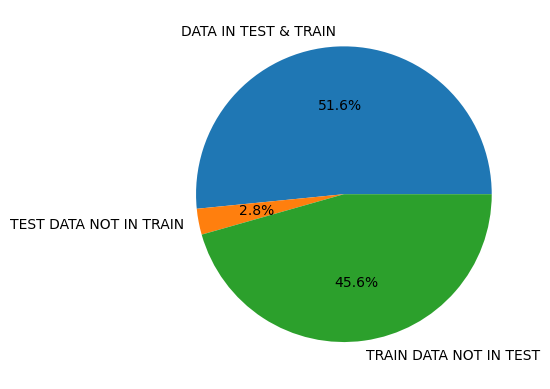

,category,n
0,DATA IN TEST & TRAIN,7733
1,TEST DATA NOT IN TRAIN,425
2,TRAIN DATA NOT IN TEST,6836


,product_category_test_not_in_train
0,16008-Germany
1,21108-Netherlands
2,21158-Norway
3,21159-Norway
4,21162-Norway
...,...
420,84978-Italy
421,85032C-Germany
422,85183B-Germany
423,85231B-Finland


In [22]:
cutoff_date = '2011-10-01'

train_1 = data_train(data=df_model_1, cutoff=cutoff_date)
test_1_raw = data_test_raw(data=df_model_1, cutoff=cutoff_date)

cek_1 = cek_inclusivity(train = train_1, test = test_1_raw)
list_data_test_not_in_train = list(cek_1[cek_1['category']=='TEST DATA NOT IN TRAIN']['product_country_test'])

cek_inclusivity_chart(cek_1)
display(pd.DataFrame(list_data_test_not_in_train, columns=['product_category_test_not_in_train']))

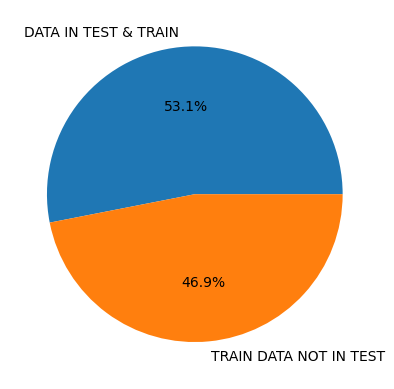

,category,n
0,DATA IN TEST & TRAIN,7733
1,TRAIN DATA NOT IN TEST,6836


In [23]:
## DROP PRODUCT & COUNTRY DATA THAT IN TEST DATA BUT NOT IN TRAIN DATA

test_1 = data_test(test_1_raw, list_data_test_not_in_train)
cek_inclusivity_chart(cek_inclusivity(train = train_1, test = test_1))

#### X & Y

In [24]:
x1_train = train_1.drop(columns='quantity')
y1_train = train_1['quantity']

x1_test = test_1.drop(columns='quantity')
y1_test = test_1['quantity']

num_columns = list(x1_train.select_dtypes(include=['int', 'float']).columns)
cat_columns = [i for i in x1_train.columns if i not in num_columns]

In [25]:
print(cat_columns)
print(num_columns)

['year_order', 'quarter_order', 'month_order', 'season', 'product_id', 'country']
['revenue', 'pre_6_quantity', 'pre_6_revenue', 'pre_6_unit_price', 'pre_6_n_customer', 'pre_6_n_order', 'pre_year_quantity', 'pre_year_revenue', 'pre_year_unit_price', 'pre_year_n_customer', 'pre_year_n_order']


### Find The Best Parameters (GRIDSEARCHCV)

In [26]:
param_grid_1 = {
    'algo__tree_method': ["hist", "exact", "approx"],
    'algo__objective': ["reg:tweedie", "reg:squarederror", "reg:squaredlogerror", "reg:gamma"]
}

grid_1 = GridSearchCV(xgb_1(num_columns=num_columns), param_grid_1, scoring={
                                                                    'MAPE' : 'neg_mean_absolute_percentage_error'
                                                                    , 'R2' : 'r2'}
                     , refit='MAPE')

In [27]:
grid_1.fit(x1_train, y1_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['revenue',
                                                                          'pre_6_quantity',
                                                                          'pre_6_revenue',
                                                                          'pre_6_unit_price',
                                                                          'pre_6_n_customer',
                                                                          'pre_6_n_order',
                                                                          'pre_year_quantity',
                                                                          'pre_year_revenue',
                                                                          'pre_year_unit_price',
                                                                          'pre_year_n_customer',
                                                                          'pre_year_n_order'])])),
                                       ('algo',
                                        XGB...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     objective='reg:squaredlogerror', ...))]),
             param_grid={'algo__objective': ['reg:tweedie', 'reg:squarederror',
                                             'reg:squaredlogerror',
                                             'reg:gamma'],
                         'algo__tree_method': ['hist', 'exact', 'approx']},
             refit='MAPE',
             scoring={'MAPE': 'neg_mean_absolute_percentage_error', 'R2': 'r2'})

In [28]:
pd.set_option("display.max_colwidth", 2000)
pd.DataFrame.from_dict(grid_1.cv_results_)\
[['params', 'mean_test_MAPE', 'rank_test_MAPE', 'mean_test_R2', 'rank_test_R2']]

,params,mean_test_MAPE,rank_test_MAPE,mean_test_R2,rank_test_R2
0,"{'algo__objective': 'reg:tweedie', 'algo__tree_method': 'hist'}",-1.060415,5,0.517879,3
1,"{'algo__objective': 'reg:tweedie', 'algo__tree_method': 'exact'}",NaN,9,NaN,9
2,"{'algo__objective': 'reg:tweedie', 'algo__tree_method': 'approx'}",-1.134057,6,0.487433,6
3,"{'algo__objective': 'reg:squarederror', 'algo__tree_method': 'hist'}",-1.370732,7,0.512394,4
4,"{'algo__objective': 'reg:squarederror', 'algo__tree_method': 'exact'}",NaN,9,NaN,9
5,"{'algo__objective': 'reg:squarederror', 'algo__tree_method': 'approx'}",-1.370732,7,0.512394,4
6,"{'algo__objective': 'reg:squaredlogerror', 'algo__tree_method': 'hist'}",-0.764197,2,0.130642,7
7,"{'algo__objective': 'reg:squaredlogerror', 'algo__tree_method': 'exact'}",NaN,9,NaN,9
8,"{'algo__objective': 'reg:squaredlogerror', 'algo__tree_method': 'approx'}",-0.758417,1,0.126220,8
9,"{'algo__objective': 'reg:gamma', 'algo__tree_method': 'hist'}",-1.038934,4,0.521037,2


In [29]:
grid_1.best_params_

{'algo__objective': 'reg:squaredlogerror', 'algo__tree_method': 'approx'}

### Running Model

In [30]:
model_xgb_1 = xgb_1(num_columns=num_columns).fit(x1_train, y1_train)
model_xgb_1

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['revenue', 'pre_6_quantity',
                                                   'pre_6_revenue',
                                                   'pre_6_unit_price',
                                                   'pre_6_n_customer',
                                                   'pre_6_n_order',
                                                   'pre_year_quantity',
                                                   'pre_year_revenue',
                                                   'pre_year_unit_price',
                                                   'pre_year_n_customer',
                                                   'pre_year_n_order'])])),
                ('algo',
                 XGBRegressor(base_score=No...
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None,
                              objective='reg:squaredlogerror', ...))])

### Evaluation Metrics

In [31]:
EVA_XGB1 = eva_matrix(model_xgb_1, x1_train, x1_test, y1_train, y1_test, 'XGB 1')
EVA_XGB1.head()

,XGB 1Training,XGB 1Testing
R2,0.070644,0.132648
MAPE,1.037440,0.839096


## MODEL 2

__ONLY SMOOTH & ERRATIC DEMAND PATTERN__

### Splitting Data

#### TEST & TRAIN

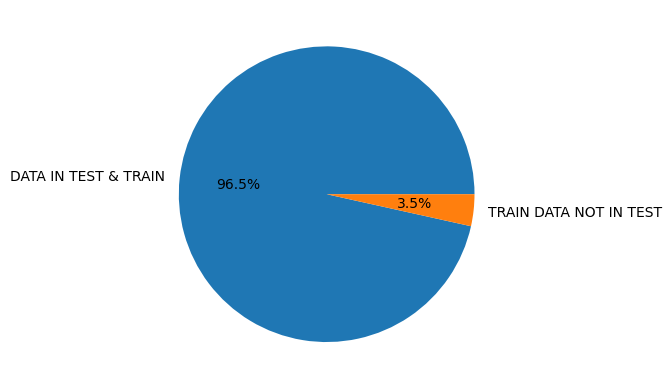

,category,n
0,DATA IN TEST & TRAIN,1666
1,TRAIN DATA NOT IN TEST,60


,product_category_test_not_in_train


In [32]:
cutoff_date = '2011-10-01'

train_2 = data_train(data=df_model_2, cutoff=cutoff_date)
test_2_raw = data_test_raw(data=df_model_2, cutoff=cutoff_date)

cek_2 = cek_inclusivity(train = train_2, test = test_2_raw)
list_data_test_not_in_train_2 = list(cek_2[cek_2['category']=='TEST DATA NOT IN TRAIN']['product_country_test'])

cek_inclusivity_chart(cek_2)
display(pd.DataFrame(list_data_test_not_in_train_2, columns=['product_category_test_not_in_train']))

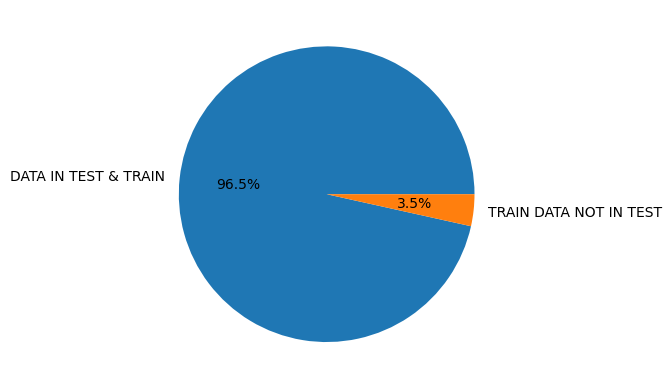

,category,n
0,DATA IN TEST & TRAIN,1666
1,TRAIN DATA NOT IN TEST,60


In [33]:
## DROP PRODUCT & COUNTRY DATA THAT IN TEST DATA BUT NOT IN TRAIN DATA

test_2 = data_test(test_2_raw, list_data_test_not_in_train_2)
cek_inclusivity_chart(cek_inclusivity(train = train_2, test = test_2))

#### X & Y

In [34]:
x2_train = train_2.drop(columns='quantity')
y2_train = train_2['quantity']

x2_test = test_2.drop(columns='quantity')
y2_test = test_2['quantity']

num_columns = list(x2_train.select_dtypes(include=['int', 'float']).columns)
cat_columns = [i for i in x2_train.columns if i not in num_columns]

In [35]:
print(cat_columns)
print(num_columns)

['year_order', 'quarter_order', 'month_order', 'season', 'product_id', 'country']
['revenue', 'pre_6_quantity', 'pre_6_revenue', 'pre_6_unit_price', 'pre_6_n_customer', 'pre_6_n_order', 'pre_year_quantity', 'pre_year_revenue', 'pre_year_unit_price', 'pre_year_n_customer', 'pre_year_n_order']


### Find The Best Parameters (GRIDSEARCHCV)

In [36]:
param_grid_2 = {
    'algo__tree_method': ["hist", "exact", "approx"],
    'algo__objective': ["reg:tweedie", "reg:squarederror", "reg:squaredlogerror", "reg:gamma"]
}

grid_2 = GridSearchCV(xgb_2(num_columns=num_columns), param_grid_2, scoring={
                                                                    'MAPE' : 'neg_mean_absolute_percentage_error'
                                                                    , 'R2' : 'r2'}
                     , refit='MAPE')

In [37]:
grid_2.fit(x2_train, y2_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['revenue',
                                                                          'pre_6_quantity',
                                                                          'pre_6_revenue',
                                                                          'pre_6_unit_price',
                                                                          'pre_6_n_customer',
                                                                          'pre_6_n_order',
                                                                          'pre_year_quantity',
                                                                          'pre_year_revenue',
                                                                          'pre_year_unit_price',
                                                                          'pre_year_n_customer',
                                                                          'pre_year_n_order'])])),
                                       ('algo',
                                        XGB...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     objective='reg:gamma', ...))]),
             param_grid={'algo__objective': ['reg:tweedie', 'reg:squarederror',
                                             'reg:squaredlogerror',
                                             'reg:gamma'],
                         'algo__tree_method': ['hist', 'exact', 'approx']},
             refit='MAPE',
             scoring={'MAPE': 'neg_mean_absolute_percentage_error', 'R2': 'r2'})

In [38]:
pd.set_option("display.max_colwidth", 2000)
pd.DataFrame.from_dict(grid_2.cv_results_)\
[['params', 'mean_test_MAPE', 'rank_test_MAPE', 'mean_test_R2', 'rank_test_R2']]

,params,mean_test_MAPE,rank_test_MAPE,mean_test_R2,rank_test_R2
0,"{'algo__objective': 'reg:tweedie', 'algo__tree_method': 'hist'}",-0.673612,4,0.704480,4
1,"{'algo__objective': 'reg:tweedie', 'algo__tree_method': 'exact'}",NaN,9,NaN,9
2,"{'algo__objective': 'reg:tweedie', 'algo__tree_method': 'approx'}",-0.668759,3,0.705688,3
3,"{'algo__objective': 'reg:squarederror', 'algo__tree_method': 'hist'}",-0.914076,7,0.690496,5
4,"{'algo__objective': 'reg:squarederror', 'algo__tree_method': 'exact'}",NaN,9,NaN,9
5,"{'algo__objective': 'reg:squarederror', 'algo__tree_method': 'approx'}",-0.914076,7,0.690496,5
6,"{'algo__objective': 'reg:squaredlogerror', 'algo__tree_method': 'hist'}",-0.674692,5,0.100401,7
7,"{'algo__objective': 'reg:squaredlogerror', 'algo__tree_method': 'exact'}",NaN,9,NaN,9
8,"{'algo__objective': 'reg:squaredlogerror', 'algo__tree_method': 'approx'}",-0.677545,6,0.099639,8
9,"{'algo__objective': 'reg:gamma', 'algo__tree_method': 'hist'}",-0.656771,2,0.713056,2


In [39]:
grid_2.best_params_

{'algo__objective': 'reg:gamma', 'algo__tree_method': 'approx'}

### Running Model

In [40]:
model_xgb_2 = xgb_2(num_columns=num_columns).fit(x2_train, y2_train)
model_xgb_2

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['revenue', 'pre_6_quantity',
                                                   'pre_6_revenue',
                                                   'pre_6_unit_price',
                                                   'pre_6_n_customer',
                                                   'pre_6_n_order',
                                                   'pre_year_quantity',
                                                   'pre_year_revenue',
                                                   'pre_year_unit_price',
                                                   'pre_year_n_customer',
                                                   'pre_year_n_order'])])),
                ('algo',
                 XGBRegressor(base_score=No...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, objective='reg:gamma', ...))])

### Evaluation Metrics

In [41]:
EVA_XGB2 = eva_matrix(model_xgb_2, x2_train, x2_test, y2_train, y2_test, 'XGB 2')
EVA_XGB2.head()

,XGB 2Training,XGB 2Testing
R2,0.793430,0.829477
MAPE,0.550623,0.283917


## EVALUATION MATRIX MODELS

In [42]:
comparison_EVA = pd.concat([EVA_XGB1, EVA_XGB2], axis=1)[[i for i in pd.concat([EVA_XGB1, EVA_XGB2], axis=1).columns if "Testing" in i]]
comparison_EVA

,XGB 1Testing,XGB 2Testing
R2,0.132648,0.829477
MAPE,0.839096,0.283917


__INSIGHT__

Use XGB 2 Model becasu the MAPE is the Lowest. Meaning we only can predict demand of certain product in certain country that has Smooth & Erratic Pattern

In [43]:
df_demand_class = df_model_raw[['demand_class', 'product_country']].drop_duplicates()\
    .groupby(['demand_class'])\
    .agg({'product_country':'nunique'}).rename(columns={'product_country':'n_product_country'}).reset_index()

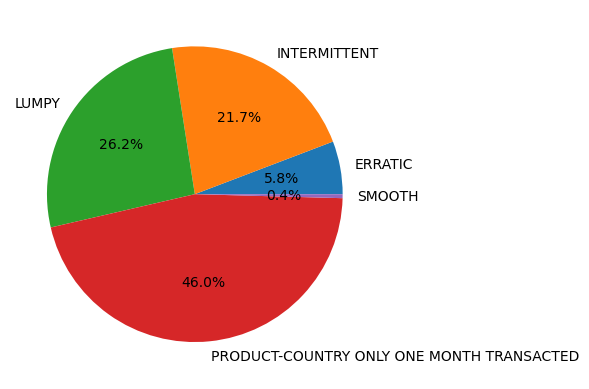

,demand_class,n_product_country
0,ERRATIC,1607
1,INTERMITTENT,6012
2,LUMPY,7256
3,PRODUCT-COUNTRY ONLY ONE MONTH TRANSACTED,12750
4,SMOOTH,119


In [44]:
plt.pie(df_demand_class['n_product_country'], labels=df_demand_class['demand_class'], autopct='%1.1f%%')
plt.show()

display(df_demand_class)

- Model XGB 2 can only predict 6131 combination product & country (6.2%), 
- Product that only purchased in one month (from 24 months) in certain country is dominating (46%). Surely we cannot predict the demand if the product & country only have 1 data point
- Here the number of products that can be predict for model XGB2 per country with example of product_id

In [45]:
print('NUMBER OF PRODUCTS PER COUNTRY AND EXAMPLE OF PRODUCTS THAT CAN BE PREDICTED BY XGB2')

display(pd.merge(
    df_model_raw[df_model_raw['demand_class'].isin(['SMOOTH','ERRATIC'])]\
    .groupby('country').agg({'product_id':'nunique'}).reset_index().rename(columns={'product_id' : 'n_product'})
    , df_model_raw[df_model_raw['demand_class'].isin(['SMOOTH','ERRATIC'])]\
    .groupby('country', as_index=False)['product_id']\
                        .agg(lambda x: ', '.join(map(str, set(x))))
    , how='left'
    , on = 'country'   
))

NUMBER OF PRODUCTS PER COUNTRY AND EXAMPLE OF PRODUCTS THAT CAN BE PREDICTED BY XGB2


,country,n_product,product_id
0,Belgium,1,POST
1,EIRE,22,"21524, 84991, 22283, 48129, 84992, 20914, 21539, 21790, 22138, 21212, C2, 20725, 84378, 22423, 15056N, 21977, 85123A, 22139, 21523, 21843, 22197, 84978"
2,France,40,"20724, 21094, 20712, 22555, 22554, 20682, 21156, 22326, 21559, 20726, 22356, 84997C, 21080, 22382, 21212, 20725, 21086, 22423, 22029, 84997B, 22328, 22303, 85099B, 22435, 48138, 84879, 22090, 21731, 22383, 20750, POST, 20719, 21121, 22139, 47566, 22551, 22352, 20749, 22027, 22556"
3,Germany,44,"21577, 20724, 21578, 20685, 21240, 21914, 21094, 20712, 22355, 22555, 22554, 21481, 22326, 21976, 21672, 21559, 20726, 22333, 21080, 21212, 21242, 21232, 22331, 22423, 84997B, 22328, 22303, 21238, 85099B, 21668, 21210, 22386, 20676, 21731, 20750, POST, 20719, 22551, 22139, 22505, 22352, 21086, 22556, 22077"
4,Netherlands,7,"22326, 20724, 22029, 21731, 22328, 20719, POST"
5,Portugal,1,POST
6,Spain,1,POST
7,Sweden,1,POST
8,Switzerland,1,POST
9,United Kingdom,1608,"21845, 21094, 22255, 21201, 21706, 85049F, 22068, 82580, 22029, 22479, 22171, 22312, 22565, 22129, DOT, 21519, 17012A, 47422, 21246, 21875, 22092, 22614, 84568, 16238, 21620, 22538, 21716, 22346, 37449, 21942, 21366, 21441, 47593B, 20839, 90214E, 21562, 22210, 22303, 84559B, 21874, 21801, 47590B, 22635, 22104, 22291, 21175, 21381, 84247G, 21670, 85159B, 21972, 21872, 21987, 22175, 21643, 21509, 21534, 21313, 20725, 22481, 82482, 22098, 22507, 47590A, 21700, 82581, 21695, 22269, 20705, 21189, 22501, 20986, 21523, 21828, 85036A, 22624, 21747, 22097, 21622, 37448, 22554, 21469, 22547, 84580, 22325, 84581, 85169B, 84946, 21849, 72802A, 21618, 21131, 21495, 20700, 21164, 47599B, 21718, 20984, 20749, 21713, 84356, 22465, 90200B, 21112, 84459A, 85071B, 22361, 22024, 22327, 21132, 85039C, 15058B, 22623, 22457, 20941, 22085, 21155, 84912B, 84673A, 22191, 21215, 21411, 22621, 22319, 15034, 85123A, 85048, 85231B, 20653, 21578, 21340, 85227, 85049E, 15036, 21374, 21383, 84508B, 21284, 22499, 85099C, 20765, 21774, 22025, 20867, 21758, C2, 21684, 22543, 22546, 85054, 21588, 84006, 22468, 22426, 16237, 21051, 20750, 22071, 21715, 17012B, 21851, 22539, 22227, 90214J, 20775, 85020, 21471, 20677, 84989A, 21664, 22619, 22530, 21239, 16216, 22061, 21557, 85038, 72800C, 22706, 90161C, 90018A, 21930, 84997D, 22149, 22692, 16218, 17012F, 72819, 21731, 85114C, 21644, 35004B, 46118, 21730, 21429, 71477, 84991, 21654, 21041, 20755, 47481, 84360, 21666, 46775D, 21163, 85053, 21672, 85184C, 22138, 22532, 22423, 21418, 22570, 22023, 84660C, 22469, 21613, 22545, 22165, 22714, 40016, 22559, 85129C, 22302, 22033, 22027, 22077, 90200E, 72802C, 20674, 22360, 21980, 21934, 84508C, 21128, 20702, 20754, 17084N, 21592, 85049C, 22251, 84031B, 20711, 22435, 90214C, 21159, 21035, 22038, 21375, 22180, 21677, 22417, 20972, 85177, 85230A, 47367B, 85163B, 85150, 22329, 22522, 20956, 22379, 21064, 84931A, 21504, 21723, 21668, 85127, 21157, 20998, 22317, 22433, 21555, 21380, 48129, 48187, 16169M, 21726, 2167..."


## Feature Importances

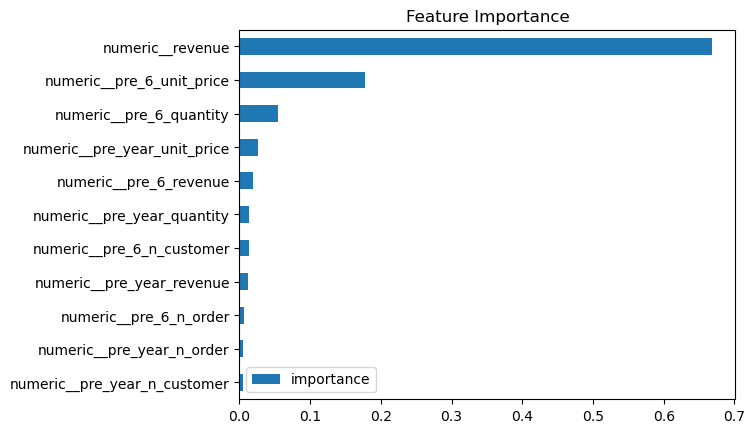

In [46]:
pd.DataFrame(
        data=model_xgb_2['algo'].feature_importances_
        , index=model_xgb_2[:-1].get_feature_names_out()
        , columns=['importance']
).sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Prediction

In [47]:
test_2['prediction'] = model_xgb_2.predict(x2_test)
df_predict = pd.merge(
                    df_model_2
                    , test_2[['year_order', 'month_order', 'product_id', 'country', 'prediction']]
                    , how='left'
                    , on=['year_order','month_order','product_id','country'])


df_predict_agg = df_predict.groupby('year_month_order').agg({'quantity':'sum', 'prediction':'sum'}).reset_index()

df_act_chart = df_predict_agg[['year_month_order', 'quantity']]
df_act_chart['type'] = 'Actual'

df_pred_chart = df_predict_agg[df_predict_agg['prediction']!= 0][['year_month_order', 'prediction']].rename(columns={'prediction':'quantity'})
df_pred_chart['type'] = 'Prediction'

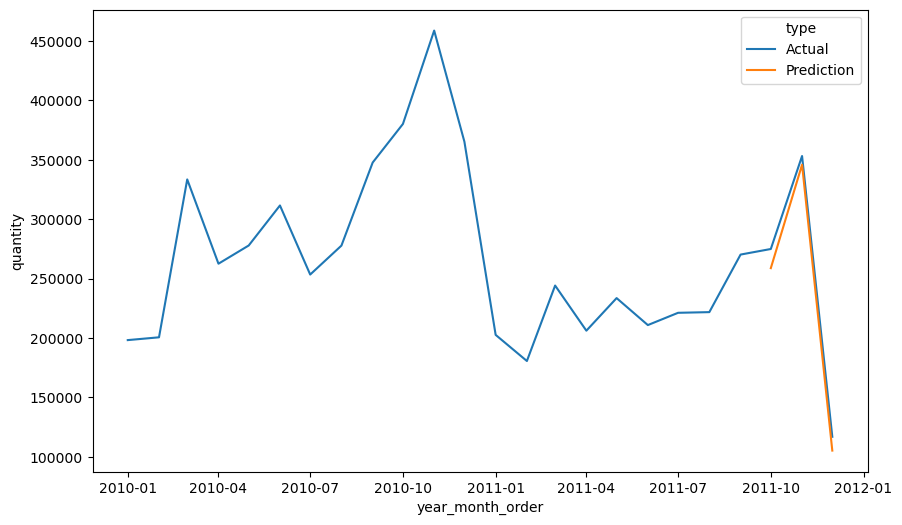

In [48]:
plt.subplots(figsize=(10, 6))
sns.lineplot(data=pd.concat([df_act_chart, df_pred_chart]), x='year_month_order', y='quantity', hue='type')
plt.show()

## MAPE Per Product_Country combination

In [49]:
df_ape = df_predict\
            [(df_predict['year_order'].astype('int')==2011)&(df_predict['month_order'].astype('int')>=10)]\
            [['year_month_order', 'product_id', 'country', 'quantity', 'prediction']]
df_ape['product_country'] = df_ape[['product_id','country']].agg('-'.join, axis=1)
df_ape['APE'] = abs(df_ape['quantity'] - df_ape['prediction'])/df_ape['quantity']

In [50]:
df_mape = df_ape.groupby('product_country').agg({'quantity':'sum', 'APE':'mean', 'prediction':'sum'})\
            .reset_index().rename(columns={'APE':'MAPE'}).sort_values('quantity', ascending=False)

# df_mape[df_mape['MAPE'] > 10]

df_mape

,product_country,quantity,MAPE,prediction
823,22197-United Kingdom,23231,0.338111,13998.314453
1365,84077-United Kingdom,13530,0.184410,14576.778320
732,22086-United Kingdom,13045,0.397646,12789.380859
1537,85099B-United Kingdom,11496,0.256962,8485.974609
1441,84879-United Kingdom,8830,0.068858,8472.414062
...,...,...,...,...
691,22033-United Kingdom,1,0.179830,1.179830
1616,90129A-United Kingdom,1,0.317522,1.317522
1550,85124C-United Kingdom,1,0.087760,1.087760
277,21202-United Kingdom,1,0.244069,1.244069


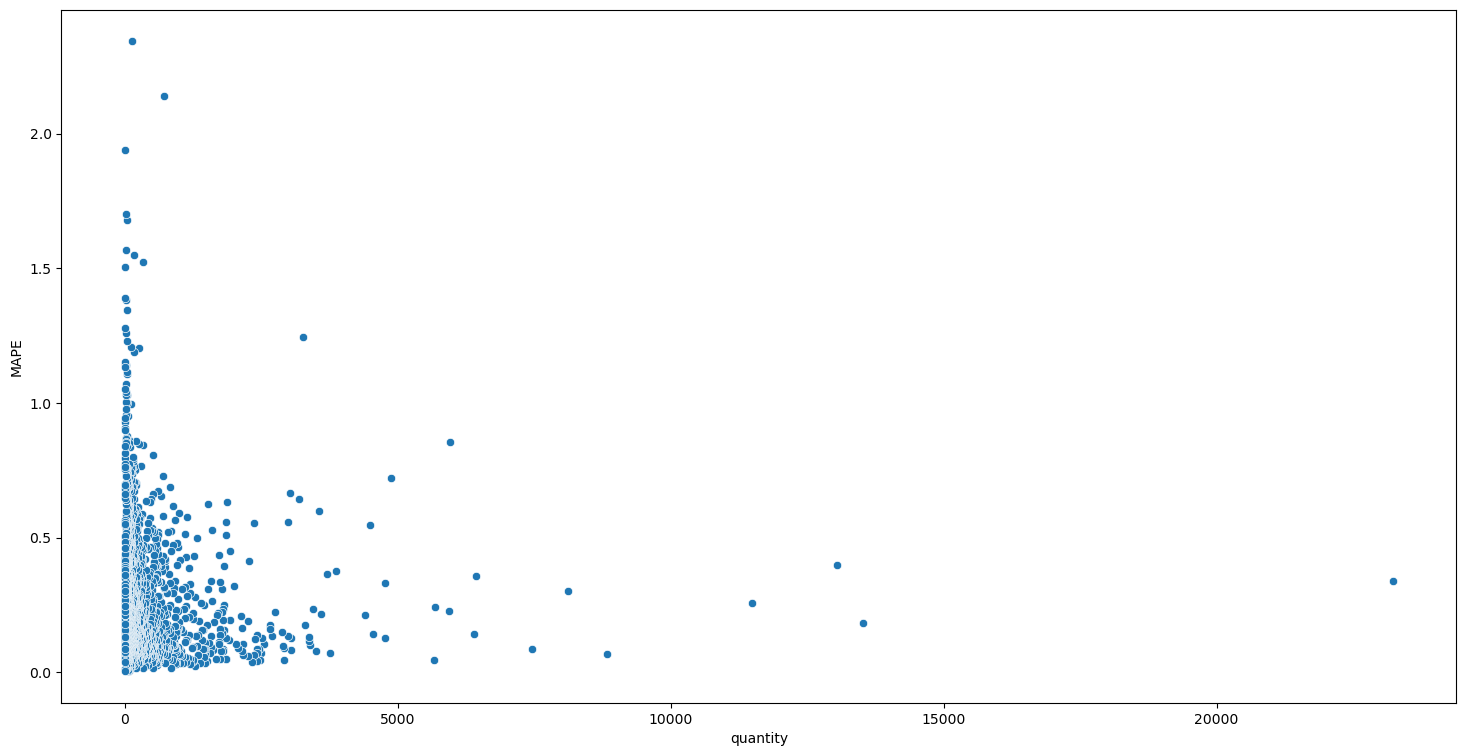

In [51]:
plt.subplots(figsize=(18, 9))

sns.scatterplot(data=df_mape, x='quantity', y='MAPE')
plt.show()

(array([3.919e+03, 5.930e+02, 5.900e+01, 2.500e+01, 8.000e+00, 3.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([2.89770273e-05, 5.63021418e-01, 1.12601386e+00, 1.68900630e+00,
        2.25199874e+00, 2.81499118e+00, 3.37798362e+00, 3.94097606e+00,
        4.50396850e+00, 5.06696094e+00, 5.62995338e+00]),
 <BarContainer object of 10 artists>)

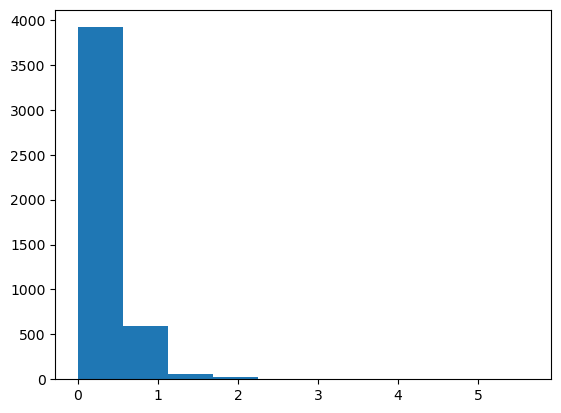

In [52]:
plt.hist(df_ape['APE'])

# PREDICTING THE FUTURE

__CRITERIA__ : 

DATASET SHOULD BE
1. for the next 6 month (2012-01-01 until 2012-06-01) (monthly)
2. only for product & country that in __SMOOTH & ERRATIC__ demand pattern
3. Revenue = Target Revenue per month, product & country for the next 6 month
   - Assume that the target __at least same as last year in each month + growth last year__
   - i.e on Target Revenue 2012-01-01 for product A in Country A = (Revenue 2011-01-01 for product A in Country A) + (Growth Revenue for product A in Country A between 2011-01-01 & 2010-01-01)
   - if the growth < 0 then 0
4. last 6 months of quantity, revenue, unit_price, n_customer & n_order in every month, product & country
5. last year of quantity, revenue, unit_price, n_customer & n_order in every month, product & country


BUT BEFORE THAT, RE-TRAIN THE MODEL FOR FULL TIME 

## RE-TRAIN MODEL (FINAL)

In [53]:
x_train_final = df_model_2.drop(columns=['year_month_order', 'quantity'])
y_train_final = df_model_2['quantity']

In [54]:
model_xgb_final = xgb_2(num_columns=num_columns).fit(x_train_final, y_train_final)
model_xgb_final

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['revenue', 'pre_6_quantity',
                                                   'pre_6_revenue',
                                                   'pre_6_unit_price',
                                                   'pre_6_n_customer',
                                                   'pre_6_n_order',
                                                   'pre_year_quantity',
                                                   'pre_year_revenue',
                                                   'pre_year_unit_price',
                                                   'pre_year_n_customer',
                                                   'pre_year_n_order'])])),
                ('algo',
                 XGBRegressor(base_score=No...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, objective='reg:gamma', ...))])

## PREPARING DATASET FOR THE FUTURE

In [55]:
dataset_raw = df_model_raw_1[df_model_raw_1['demand_class'].isin(['SMOOTH', 'ERRATIC'])]
dataset_raw = dataset_raw.groupby(['year_month_order', 'year_order', 'quarter_order', 'month_order','season'
                                   ,'product_id', 'country'])\
                            .agg({'quantity':'sum'
                                  , 'revenue' : 'sum'
                                  , 'unit_price' : 'median'
                                  , 'customer_id' : 'nunique'
                                  , 'order_id' : 'nunique'
                                 }).reset_index().rename(columns={'customer_id':'n_customer', 'order_id':'n_order'})

In [56]:
def dataset_future(start_date, end_date) : 
    df_date = pd.DataFrame(pd.date_range(start_date, end_date, freq='MS')).rename(columns={0:'year_month_order'})
    data_product_country_un = dataset_raw[['product_id', 'country']].drop_duplicates()

    df_date['key'] = 0
    data_product_country_un['key'] = 0

    df_raw = pd.merge(df_date, data_product_country_un, how='outer', on='key').drop(columns=['key'])
    
    df_raw['year_order'] = df_raw['year_month_order'].dt.year.astype('str')
    df_raw['quarter_order'] = df_raw['year_month_order'].dt.quarter.astype('str')
    df_raw['month_order'] = df_raw['year_month_order'].dt.month.astype('str')
    df_raw['season'] = np.where(df_raw['month_order'].astype('str').isin(['12','1', '2']), 'Winter', 
                           np.where(df_raw['month_order'].astype('str').isin(['3','4', '5']), 'Spring', 
                                   np.where(df_raw['month_order'].astype('str').isin(['6','7', '8']), 'Summer', 'Fall')))
    df_raw['last_year'] = df_raw['year_month_order']- DateOffset(months=12)
    df_raw['last_2_year'] = df_raw['year_month_order']- DateOffset(months=24)
    df_raw['last_6_month'] = df_raw['year_month_order']- DateOffset(months=6)

    ## GET PRE YEAR
    df_raw_1 = pd.merge(
        df_raw
        , dataset_raw[['year_month_order', 'product_id', 'country', 'revenue', 'quantity', 'unit_price', 'n_customer', 'n_order']]
        , how = 'left'
        , left_on = ['last_year', 'product_id', 'country']
        , right_on = ['year_month_order', 'product_id', 'country']
    ).rename(columns={
                'revenue':'pre_year_revenue', 'quantity': 'pre_year_quantity'
                , 'unit_price':'pre_year_unit_price', 'n_customer':'pre_year_n_customer', 'n_order':'pre_year_n_order'})\
    .drop(columns=['year_month_order_x','year_month_order_y', 'last_year'])
    
    ## GET REVENUE (GROW REVENUE, LAST 2 YEARS)
    df_raw_2 = pd.merge(
        df_raw_1
        , dataset_raw[['year_month_order', 'product_id', 'country', 'revenue']]
        , how = 'left'
        , left_on = ['last_2_year', 'product_id', 'country']
        , right_on = ['year_month_order', 'product_id', 'country']
    ).rename(columns={'revenue':'pre_2_year_revenue'})\
    .drop(columns=['last_2_year'])

    df_raw_2['grow_revenue'] = df_raw_2['pre_year_revenue'] - df_raw_2['pre_2_year_revenue']
    df_raw_2['grow_revenue'] = np.where(df_raw_2['grow_revenue'].isnull(), 0
                                        , np.where(df_raw_2['grow_revenue'] < 0, 0, df_raw_2['grow_revenue']))
    df_raw_2['revenue'] = df_raw_2['pre_year_revenue'] + df_raw_2['grow_revenue']

    df_raw_2 = df_raw_2[['year_order', 'quarter_order', 'month_order', 'season', 'product_id', 'country'
                        , 'revenue', 'pre_year_quantity', 'pre_year_revenue', 'pre_year_unit_price'
                        , 'pre_year_n_customer', 'pre_year_n_order', 'last_6_month']]

    ## GET PRE 6 MONTH
    df_raw_3 = pd.merge(
        df_raw_2
        , dataset_raw[['year_month_order', 'product_id', 'country', 'revenue', 'quantity', 'unit_price', 'n_customer', 'n_order']]
        , how = 'left'
        , left_on = ['last_6_month', 'product_id', 'country']
        , right_on = ['year_month_order', 'product_id', 'country']
    ).rename(columns={
                'revenue_x':'revenue', 'revenue_y':'pre_6_revenue', 'quantity': 'pre_6_quantity'
                , 'unit_price':'pre_6_unit_price', 'n_customer':'pre_6_n_customer', 'n_order':'pre_6_n_order'})\
    .drop(columns=['year_month_order', 'last_6_month'])
    
    return df_raw_3

In [57]:
# aa('2012-01-01', '2012-06-01')[aa('2012-01-01', '2012-06-01')['revenue'].isnull()]

dataset_future('2012-01-01', '2012-06-01').head()

,year_order,quarter_order,month_order,season,product_id,country,revenue,pre_year_quantity,pre_year_revenue,pre_year_unit_price,pre_year_n_customer,pre_year_n_order,pre_6_revenue,pre_6_quantity,pre_6_unit_price,pre_6_n_customer,pre_6_n_order
0,2012,1,1,Winter,10120,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,1.05,5.0,0.21,1.0,1.0
1,2012,1,1,Winter,10125,United Kingdom,163.92,153.0,84.45,0.790,5.0,25.0,66.23,77.0,0.85,8.0,8.0
2,2012,1,1,Winter,10133,United Kingdom,216.67,180.0,113.84,0.810,5.0,21.0,399.86,790.0,0.42,30.0,51.0
3,2012,1,1,Winter,10135,United Kingdom,914.76,613.0,487.38,1.250,16.0,42.0,208.75,167.0,1.25,8.0,8.0
4,2012,1,1,Winter,11001,United Kingdom,30.40,17.0,30.40,2.525,2.0,2.0,190.82,204.0,0.83,3.0,24.0


## Predict Future

In [58]:
df_next_6 = dataset_future('2012-01-01', '2012-06-01')
df_next_6['quantity'] = model_xgb_final.predict(df_next_6)
df_next_6['year_month_order'] = df_next_6['year_order'].astype('str')+'-'+df_next_6['month_order'].astype('str')+'-01'
df_next_6['year_month_order'] = pd.to_datetime(df_next_6['year_month_order'])

df_next_6['cat'] = 'FUTURE'
dataset_raw['cat'] = 'HISTORICAL'

In [59]:
df_next_6.head()

,year_order,quarter_order,month_order,season,product_id,country,revenue,pre_year_quantity,pre_year_revenue,pre_year_unit_price,pre_year_n_customer,pre_year_n_order,pre_6_revenue,pre_6_quantity,pre_6_unit_price,pre_6_n_customer,pre_6_n_order,quantity,year_month_order,cat
0,2012,1,1,Winter,10120,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,1.05,5.0,0.21,1.0,1.0,2290.331055,2012-01-01,FUTURE
1,2012,1,1,Winter,10125,United Kingdom,163.92,153.0,84.45,0.790,5.0,25.0,66.23,77.0,0.85,8.0,8.0,224.531128,2012-01-01,FUTURE
2,2012,1,1,Winter,10133,United Kingdom,216.67,180.0,113.84,0.810,5.0,21.0,399.86,790.0,0.42,30.0,51.0,505.202759,2012-01-01,FUTURE
3,2012,1,1,Winter,10135,United Kingdom,914.76,613.0,487.38,1.250,16.0,42.0,208.75,167.0,1.25,8.0,8.0,671.055908,2012-01-01,FUTURE
4,2012,1,1,Winter,11001,United Kingdom,30.40,17.0,30.40,2.525,2.0,2.0,190.82,204.0,0.83,3.0,24.0,25.995064,2012-01-01,FUTURE


In [60]:
df_all_future = pd.concat([
            dataset_raw[['year_month_order', 'product_id', 'country', 'quantity', 'cat']]
         , df_next_6[['year_month_order', 'product_id', 'country', 'quantity', 'cat']]
])

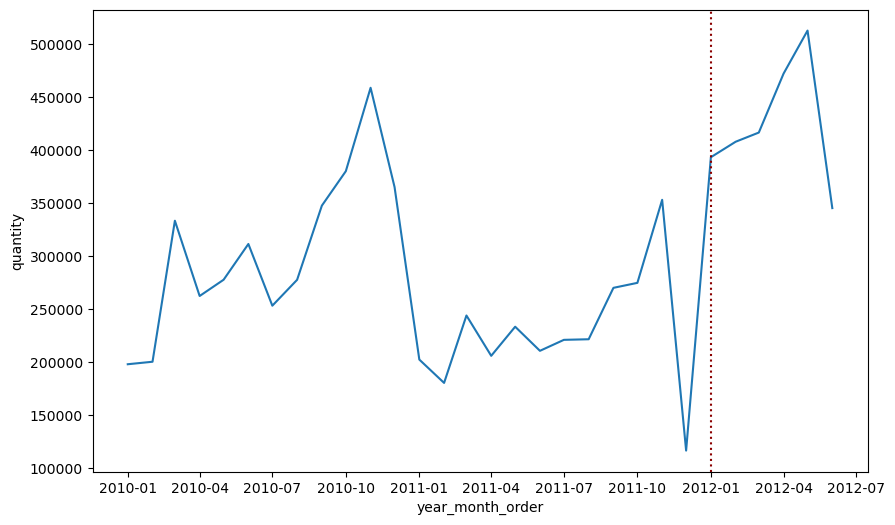

In [61]:
df_all_future_agg = df_all_future.groupby(['year_month_order', 'cat']).agg({'quantity':'sum'}).reset_index()

plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=df_all_future_agg, x='year_month_order', y='quantity')
ax.axvline(dt.datetime(2012, 1, 1), color='darkred' , ls=':')
plt.show()

__INSIGHT__ : 

- the demand for the next 5 month would be increasing significantly, but on June, 2012 the demand will decreasing.

In [62]:
df_all_future.groupby(['product_id', 'country']).agg({'quantity':'sum'})\
.reset_index().sort_values('quantity', ascending=False).iloc[0:10]

,product_id,country,quantity
1410,84077,United Kingdom,122185.937988
860,22197,United Kingdom,104367.280518
1593,85099B,United Kingdom,104171.015869
1604,85123A,United Kingdom,100670.480957
1493,84879,United Kingdom,83169.278076
41,17003,United Kingdom,81554.885284
308,21212,United Kingdom,79680.479797
698,21977,United Kingdom,54616.470276
6,15036,United Kingdom,53629.971008
842,22178,United Kingdom,52069.897339


__INSISIGHT__ : 

- Top Ten Highest demand are in UK with maximum quantity 122,185

__RECCOMENDATION__ : 

1. Prepare the Stock of the product for next 6 months, prioritizing for high demand product in UK